This project is using housing data with 81 initial columns and 1460 rows. Many more columns were added after incluing dummies...Up to 399. I made a decision tree model first, which executed in .4 seconds, and had .65 accuracy. I tried to beat that with random forest in a few seperate ways. The 3 hyperparameters I focused on in my random forest modeling was max_depth, number of trees, and max_features. The most notable increase in performance without loss of much accuracy was max_features. When generating each tree, the model only considers randomly chosen square root of the total number of features. With this setting, even without that many trees, I was able to beat the performance of the decision tree AND do it in less processing time. Without care for processing time, I get over 85% accuracy with random forest. With 13 trees and max depth of 20 and using the sqrt of the max features, I get about 83% accuracy at the same processing time as the decision tree.

Very obvious boost in performance of the random forest over just a basic decision tree. I will also add that between the 3 hyperparameters I investigated on this problem, max_features seems to be the biggest boost in speed with the least sacrifice in accuracy.

In [245]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sqlalchemy import create_engine
from scipy import stats
import statsmodels.api as sm
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
import time


import warnings
warnings.filterwarnings('ignore')

In [246]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()


In [247]:
clean_df = df.copy()
clean_df.alley.unique()
clean_df.alley.fillna('None', inplace=True)
clean_df.lotfrontage.fillna(0, inplace=True)
clean_df.masvnrtype.fillna('None', inplace=True)
clean_df.masvnrarea.fillna(0.0, inplace=True)
clean_df.bsmtqual.fillna('NA', inplace=True)
clean_df.bsmtcond.fillna('NA', inplace=True)
clean_df.bsmtexposure.fillna('NA', inplace=True)
clean_df.bsmtfintype1.fillna('NA', inplace=True)
clean_df.bsmtfintype2.fillna('NA', inplace=True)
clean_df.bsmtexposure.fillna('NA', inplace=True)
clean_df.electrical.fillna('SBrkr', inplace=True)
clean_df.fireplacequ.fillna('NA', inplace=True)
clean_df.garagetype.fillna('NA', inplace=True)
clean_df.garageyrblt.fillna('NA', inplace=True)
clean_df.garagefinish.fillna('NA', inplace=True)
clean_df.garagequal.fillna('NA', inplace=True)
clean_df.garagecond.fillna('NA', inplace=True)
clean_df.poolqc.fillna('NA', inplace=True)
clean_df.fence.fillna('NA', inplace=True)
clean_df.miscfeature.fillna('NA', inplace=True)

In [248]:
feature_df = clean_df[['lotarea', 'overallqual']].copy()
bldgtype_list = []
for i in df.bldgtype:
    if i == '2fmCon':
        bldgtype_list.append('Duplex')
    else:
        bldgtype_list.append(i)
clean_df['bldgtype'] = bldgtype_list
x = pd.get_dummies(clean_df.bldgtype, drop_first=True).copy()
for i in range(len(clean_df.bldgtype.unique()) - 1):
    feature_df['bldgtype' + clean_df.bldgtype.unique()[i + 1]] = x.iloc[:,i]

In [249]:
keywords = ['garagequal', 'kitchenqual', 'bsmtcond', 'bsmtqual', 'exterqual' ]
for word in keywords:
    nums = []
    for row in clean_df[word]:
        if row == 'Fa':
            nums.append(1)
        elif row == 'TA':
            nums.append(2)
        elif row == 'Gd':
            nums.append(3)
        elif row == 'Ex':
            nums.append(4)
        else:
            nums.append(0)
    feature_df[word] = nums

In [250]:
feature_df[['garagecars', 'firstflrsf', 'fullbath', 'totrmsabvgrd', 'yearbuilt', 'yearremodadd', 'fireplaces', 'bsmtfinsf1', 'wooddecksf', 'secondflrsf']] = clean_df[['garagecars', 'firstflrsf', 'fullbath', 'totrmsabvgrd', 'yearbuilt', 'yearremodadd', 'fireplaces', 'bsmtfinsf1', 'wooddecksf', 'secondflrsf']]
feature_df['isWDsale'] = x.iloc[:,-1]
feature_df['saleprice'] = clean_df.saleprice

In [251]:
clean_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000


In [252]:
X = pd.get_dummies(clean_df.drop('saleprice', 1))
Y = clean_df.saleprice

In [253]:
start_time = time.time()
decision_tree = tree.DecisionTreeRegressor()
cv = 6
tree_results = cross_val_score(decision_tree, X, Y, cv=cv)
print(tree_results)
total = 0
for i in tree_results:
    total += i
print(total/cv)
print("--- %s seconds ---" % (time.time() - start_time))

[0.73671256 0.77506663 0.76883515 0.60674593 0.56013221 0.433937  ]
0.6469049120061571
--- 0.39668798446655273 seconds ---


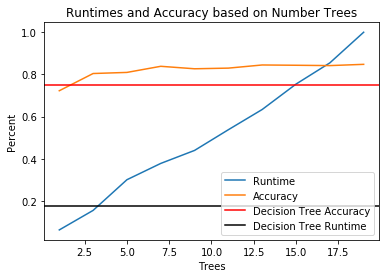

In [254]:
number_trees = []
runtimes = []
accuracy = []
for i in range(0, 20, 2):
    start_time = time.time()
    rfr = ensemble.RandomForestRegressor(n_estimators=i + 1)
    cv = 6
    forest_results = cross_val_score(rfr, X, Y, cv=cv)
    #print(forest_results)
    total = 0
    for j in forest_results:
        total += j
    number_trees.append(i+1)
    #print(" %s seconds ---" % (time.time() - start_time))
    runtimes.append((time.time() - start_time))
    #print('Accuracy: ', total/cv, '\n')
    accuracy.append(total/cv)
max_runtime = max(runtimes)
for i in range(len(runtimes)):
    runtimes[i] = runtimes[i]/max_runtime
line1 = plt.plot(number_trees, runtimes)
line2 = plt.plot(number_trees, accuracy)
line3 = plt.axhline(.75, color='r')
line4 = plt.axhline(0.7786779403686523/max_runtime, color='black')
plt.legend((line1[0], line2[0], line3, line4), ('Runtime', 'Accuracy', 'Decision Tree Accuracy', 'Decision Tree Runtime'))
plt.title('Runtimes and Accuracy based on Number Trees')
plt.xlabel('Trees')
plt.ylabel('Percent')
plt.show()
# Runtimes are scaled to make graph nicer

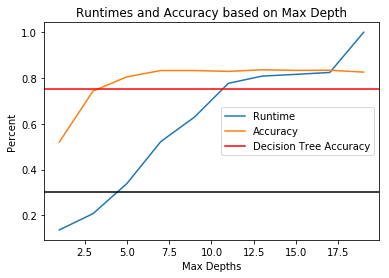

In [255]:
depths = []
runtimes = []
accuracy = []
for i in range(0, 20, 2):
    start_time = time.time()
    rfr = ensemble.RandomForestRegressor(n_estimators=10, max_depth=i+1)
    cv = 6
    forest_results = cross_val_score(rfr, X, Y, cv=cv)
    total = 0
    for j in forest_results:
        total += j
    depths.append(i+1)
    runtimes.append((time.time() - start_time))
    accuracy.append(total/cv)
max_runtime = max(runtimes)
for i in range(len(runtimes)):
    runtimes[i] = runtimes[i]/max_runtime
line1 = plt.plot(depths, runtimes)
line2 = plt.plot(depths, accuracy)
line3 = plt.axhline(.75, color='r')
line4 = plt.axhline(0.7786779403686523/max_runtime, color='black')
plt.legend((line1[0], line2[0], line3), ('Runtime', 'Accuracy', 'Decision Tree Accuracy', 'Decision Tree Runtime'))
plt.title('Runtimes and Accuracy based on Max Depth')
plt.xlabel('Max Depths')
plt.ylabel('Percent')
plt.show()

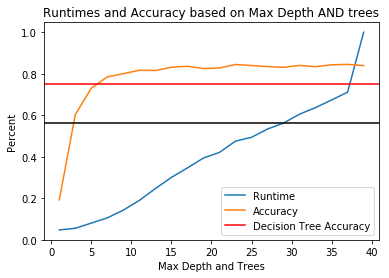

In [256]:
depths = []
runtimes = []
accuracy = []
for i in range(0, 40, 2):
    start_time = time.time()
    rfr = ensemble.RandomForestRegressor(n_estimators=i+1, max_depth=i+1, max_features='sqrt')
    cv = 6
    forest_results = cross_val_score(rfr, X, Y, cv=cv)
    total = 0
    for j in forest_results:
        total += j
    depths.append(i+1)
    runtimes.append((time.time() - start_time))
    accuracy.append(total/cv)
max_runtime = max(runtimes)
for i in range(len(runtimes)):
    runtimes[i] = runtimes[i]/max_runtime
line1 = plt.plot(depths, runtimes)
line2 = plt.plot(depths, accuracy)
line3 = plt.axhline(.75, color='r')
line4 = plt.axhline(0.7786779403686523/max_runtime, color='black')
plt.legend((line1[0], line2[0], line3), ('Runtime', 'Accuracy', 'Decision Tree Accuracy', 'Decision Tree Runtime'))
plt.title('Runtimes and Accuracy based on Max Depth AND trees')
plt.xlabel('Max Depth and Trees')
plt.ylabel('Percent')
plt.show()
# This time I set the max_features to the sqrt and increased performace speed greatly.

In [289]:
start_time = time.time()
rfr = ensemble.RandomForestRegressor(n_estimators=13, max_depth=20, max_features='sqrt')
cv = 6
forest_results = cross_val_score(rfr, X, Y, cv=cv)
total=0
for i in forest_results:
    total+=i
print('Accuracy: ', total/cv)
print('Time: ', time.time() - start_time)

Accuracy:  0.8462168748545515
Time:  2.780388832092285


In [292]:
start_time = time.time()
rfr = ensemble.RandomForestRegressor(n_estimators=100, max_features='sqrt')
cv = 6
forest_results = cross_val_score(rfr, X, Y, cv=cv)
total=0
for i in forest_results:
    total+=i
print('Accuracy: ', total/cv)
print('Time: ', time.time() - start_time)

Accuracy:  0.8475072129400871
Time:  2.831912040710449
